In [1]:
from Neural_Nets.LaengeNet.Development.LaengeNetTorch import LaengeNet, LaengeNetLossFunc
from Neural_Nets.ThermoDataset.Development.ThermoDataset import ThermoDataset
from Neural_Nets.ThermoNetActFuncs.Development.ThermoNetActFuncs import Sigmoid, ChenSundman
from Utils.PlotHandler.Development.PlotHandler import PlotHandler 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop
from Data_Handling.SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def epoch(net: LaengeNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, (temp, g, s, h, c) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)
        
        # Input scaling 
        #temp /= temp.max()

        # Forward pass
        gibbs_energy, entropy, enthalpy, heat_cap = net(temp, temp, temp, temp, debug=False)
        
        # Output scaling
        scale = 100000
        gibbs_energy, entropy, enthalpy, heat_cap = gibbs_energy/scale, entropy/scale, enthalpy/scale, heat_cap/scale
        g, s, h, c = g/scale, s/scale, h/scale, c/scale
        
        # Get the loss
        loss = loss_func(gibbs_energy.float(), g.float(), entropy.float(), s.float(), enthalpy.float(), h.float(),
                         heat_cap.float(), c.float(), debug=False)

        # Backward pass
        net.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 100)
        optimizer.step()
        epoch_losses[i] = loss

    mean_epoch_loss = epoch_losses.mean()
    print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [3]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 100
    lr = 0.01
    batch_size = 16
    std_thresh = 0.05
    loss_weights = [1, 0, 0, 0]

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = Rprop(net.parameters(), lr=lr)
    loss_func = LaengeNetLossFunc()

    losses = []
    
    # Keep track of epoch where learning rate was reduced last
    lr_reduced_last = 0

    for i in range(n_epochs):
        print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss)
        
        # Adapt learning rate if standard deviation over the last 10 epochs is below a threshold
        if np.array(losses[-10:]).std() < std_thresh and (i - lr_reduced_last) >= 10:
            print('Learning rate halfed! \n')
            lr_reduced_last = i
            lr /= 2

In [4]:
net = LaengeNet(init_args=(-0.2, -0.1), act_1=ChenSundman())

element = 'Fe'
phase = ['BCC_A2']
dataset = ThermoDataset(element, phase)

train(net, dataset)

Fe successfully selected!

-----
Epoch 0:



C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Mean epoch loss:  0.421997021905486
-----
Epoch 1:

Mean epoch loss:  0.012343338825609361
-----
Epoch 2:

Mean epoch loss:  0.011515291908181438
-----
Epoch 3:

Mean epoch loss:  0.010958465634383888
-----
Epoch 4:

Mean epoch loss:  0.010357922574104828
-----
Epoch 5:

Mean epoch loss:  0.010399726467537824
-----
Epoch 6:

Mean epoch loss:  0.010354957552017452
-----
Epoch 7:

Mean epoch loss:  0.009998700638066665
-----
Epoch 8:

Mean epoch loss:  0.009991656971451279
-----
Epoch 9:

Mean epoch loss:  0.009734322865293405
-----
Epoch 10:

Mean epoch loss:  0.009801926367663753
Learning rate halfed! 

-----
Epoch 11:

Mean epoch loss:  0.009906824543271388
-----
Epoch 12:

Mean epoch loss:  0.009720332285163
-----
Epoch 13:

Mean epoch loss:  0.009747282628004795
-----
Epoch 14:

Mean epoch loss:  0.00965590676658343
-----
Epoch 15:

Mean epoch loss:  0.009764006901010175
-----
Epoch 16:

Mean epoch loss:  0.009540772115567996
-----
Epoch 17:

Mean epoch loss:  0.00962611418826697
--

In [5]:
print('theta_E: ', net.sub_net_1.act_1.theta_E)
print('E0: ', net.sub_net_1.act_1.E0)
print('a: ', net.sub_net_1.act_1.a)
print('b: ', net.sub_net_1.act_1.b)

theta_E:  Parameter containing:
tensor(35.0000, requires_grad=True)
E0:  Parameter containing:
tensor(-37615.1953, requires_grad=True)
a:  Parameter containing:
tensor(-14.0948, requires_grad=True)
b:  Parameter containing:
tensor(0.8280, requires_grad=True)


Fe successfully selected!

tensor(1999., dtype=torch.float64)
tensor([[   -444.6172],
        [   -483.9492],
        [   -523.3516],
        ...,
        [-111986.4062],
        [-112076.7500],
        [-112167.2344]])
tensor(125947.5078, dtype=torch.float64)


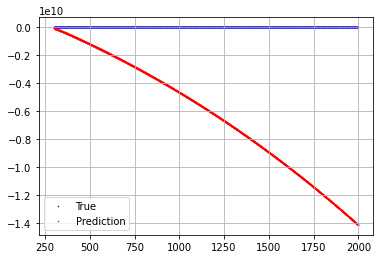

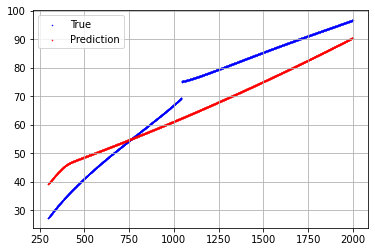

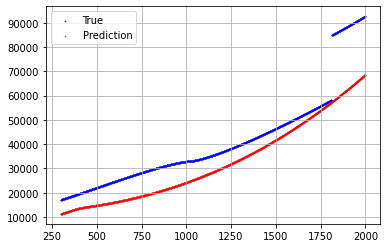

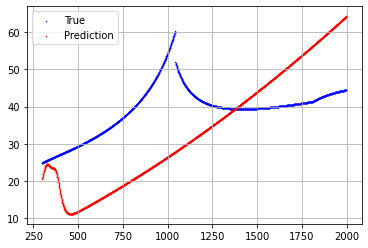

In [6]:
ph = PlotHandler('Laenge')

ph.properties_temp(net, element, phase)

In [7]:
#torch.save(net, 'LaengeNet/Models/model_12_01_22_1535')